In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from celeriteflow import ops

/Users/dforeman/anaconda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [3]:
session = tf.Session()

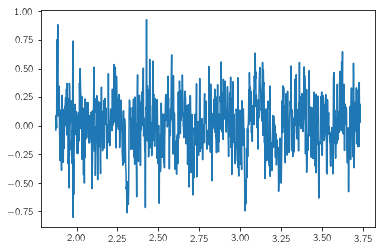

In [4]:
data = np.loadtxt('211351816.dat.ts')

T = tf.float64

t = tf.constant(data[1000:2000, 0]*0.0864, dtype=T)
y = tf.constant(data[1000:2000, 1:2]*1e3, dtype=T)

log_var = np.log(np.var(data[:,1]*1e3))

plt.plot(*(session.run([t, y])))

In [5]:
def get_param_for_value(value, min_value, max_value):
    if value <= min_value or value >= max_value:
        raise ValueError("value must be in the range (min_value, max_value)")
    return np.log(value - min_value) - np.log(max_value - value)

def get_value_for_param(param, min_value, max_value):
    return min_value + (max_value - min_value) / (1.0 + np.exp(-param))

def get_bounded_variable(name, value, min_value, max_value, dtype=tf.float64):
    param = tf.Variable(get_param_for_value(value, min_value, max_value), dtype=dtype, name=name + "_param")
    var = min_value + (max_value - min_value) / (1.0 + tf.exp(-param))
    log_jacobian = tf.log(tf.abs(tf.squeeze(tf.gradients(var, param))))
    return param, var, log_jacobian, (min_value, max_value)

In [68]:
log_prob = tf.constant(0.0, dtype=T)
log_Q_param, log_Q, log_jac, log_Q_range = get_bounded_variable("log_Q", 10.0, 8.0, 15.0, dtype=T)
log_prob += log_jac

log_numax_param, log_numax, log_jac, log_numax_range = get_bounded_variable("log_numax", np.log(200.0), np.log(150.0), np.log(300.0), dtype=T)
log_prob += log_jac

log_dnu_param, log_dnu, log_jac, log_dnu_range = get_bounded_variable("log_dnu", np.log(17.0), np.log(15.0), np.log(30.0), dtype=T)
log_prob += log_jac

In [78]:
log_jitter = tf.Variable(log_var, dtype=T, name="log_jitter")
# log_numax = tf.Variable(np.log(200.0), dtype=T, name="log_numax")
# log_dnu = tf.Variable(np.log(17.0), dtype=T, name="log_dnu")
gamma = tf.Variable([-1, 0.0], dtype=T, name="gamma")
log_H = tf.Variable([log_var, log_var], dtype=T, name="log_H")
log_sigma = tf.Variable(np.log(10.0), dtype=T, name="log_sigma")
# log_Q = tf.Variable(10., dtype=T, name="log_Q")

numax = tf.exp(log_numax)
nprime = tf.range(-2.0, 3.0, dtype=T)
ell = tf.mod(tf.range(2, dtype=T), 2)
nu = numax + gamma[None, :] + (tf.exp(log_dnu) * (nprime[:, None] + 0.5*ell[None, :]))
log_amp = log_H[None, :] - 0.5*tf.square(nu - numax)/tf.square(tf.exp(log_sigma) + tf.exp(log_dnu))

w0 = 2*np.pi*nu
Q = 1.0 + tf.exp(log_Q)  # Make sure that Q is always greater than 1
Q2 = tf.square(Q)
S0 = tf.exp(log_amp) / Q2

f = tf.sqrt(4.0 * Q2 - 1.0)
nada = tf.constant([], dtype=T)
a = tf.reshape(S0 * w0 * Q, [-1])
b = tf.reshape(S0 * w0 * Q / f, [-1])
c = tf.reshape(0.5 * w0 / Q, [-1])
d = tf.reshape(0.5 * w0 / Q * f, [-1])

# Granulation terms
log_S0_gran = tf.Variable([log_var - 10.0, log_var - 10.0], dtype=T, name="log_S0_gran")
log_w0_gran = tf.Variable(np.log([2*np.pi*100.0, 2*np.pi*150.0]), dtype=T, name="log_w0_gran")

arg1 = tf.exp(log_S0_gran + log_w0_gran)
arg2 = 0.5 * tf.exp(log_w0_gran)
a = tf.concat([arg1, a], 0)
b = tf.concat([arg1, b], 0)
c = tf.concat([arg2, c], 0)
d = tf.concat([arg2, d], 0)

# Power spectrum
freq = tf.placeholder_with_default(
    np.linspace(10, 280, 100000),
    None
)
omega = 2 * np.pi * freq
num = (a * c + b * d) * (tf.square(c) + tf.square(d)) + (a * c - b * d) * tf.square(omega)[:, None]
denom = (omega**4)[:, None] + 2*(tf.square(c) - tf.square(d)) * tf.square(omega)[:, None] + tf.square(tf.square(c) + tf.square(d)) 
psds = np.sqrt(2.0 / np.pi) * num / denom
psd = tf.reduce_sum(psds, 1)

# GP model
A, U, V, P = ops.get_celerite_matrices(nada, nada, a, b, c, d, t, tf.exp(log_jitter) + tf.zeros_like(t))
D, W = ops.celerite_factor(A, U, V, P)
z = ops.celerite_solve(U, P, D, W, y)

chi2 = tf.squeeze(tf.matmul(y, z, transpose_a=True)) + tf.reduce_sum(tf.log(D))
log_prob -= 0.5*chi2

session.run(tf.global_variables_initializer())
print(session.run(chi2))
session.run(tf.gradients(chi2, [log_S0_gran, log_w0_gran]))

-1749.42183314


[array([-7.87704698, -2.82118941]), array([  3.26087134,  10.88361394])]

In [79]:
# # Hacks to test gradients
# eps = 1e-5
# var = y
# targ = tf.reduce_sum(z)
# v = session.run(var)
# g0 = session.run(tf.gradients(targ, var))[0].flatten()

# s = v.shape
# v = v.flatten()
# g = np.empty_like(v)
# for i in range(len(v)):
#     eye = np.zeros_like(v)
#     eye[i] = eps
#     p = session.run(targ, feed_dict={var: (v+eye).reshape(s)})
#     m = session.run(targ, feed_dict={var: (v-eye).reshape(s)})
#     g[i] = 0.5 * (p - m) / eps
    
# inds = [0, 1, 2, 3, -4, -3, -2, -1]
# g[inds], g0[inds], np.max(np.abs(g - g0))

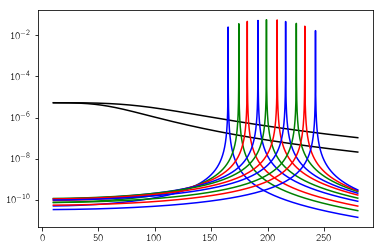

In [80]:
ids = np.concatenate((
    np.zeros(2),
    np.arange(1, 4),
    np.arange(1, 4),
    np.arange(1, 4),
    np.arange(1, 4),
    np.arange(1, 4),
)).astype(int)
colors = np.array(["k", "b", "g", "r"])[ids]
x, ys = session.run([freq, psds])
for a, b in zip(ys.T, colors):
    plt.semilogy(x, a, color=b)

In [87]:
def gridsearch(session, target, var, grid, index=0, assign=True):
    target_grid = np.empty_like(grid)
    var_init = session.run(var)
    shape = np.shape(var_init)
    var_init = np.atleast_1d(var_init)
    for i, value in enumerate(grid):
        var_init[index] = value
        target_grid[i] = session.run(target, feed_dict={var: np.reshape(var_init, shape)})
    var_init[index] = grid[np.argmin(target_grid)]
    if assign:
        session.run(tf.assign(var, np.reshape(var_init, shape)))
    return target_grid

In [94]:
#proposed schedule: 0. inititialize vars, 1.optimize gran params, 2.gridsearch gamma, 3. opt all but numax/dnu, 4. grid numax/dnu, 5. optimize all params, 6. return to 2

def optimize(variables):
    opt = tf.contrib.opt.ScipyOptimizerInterface(chi2, var_list=variables)
    opt.minimize(session)

granvariables = [log_S0_gran, log_w0_gran]

optimize(granvariables)

INFO:tensorflow:Optimization terminated with:
  Message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  Objective function value: -2018.483941
  Number of iterations: 5
  Number of functions evaluations: 48


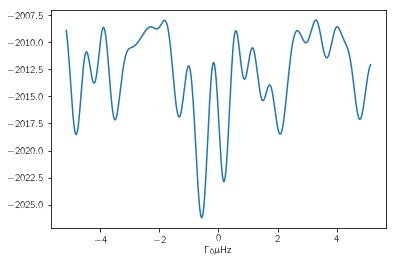

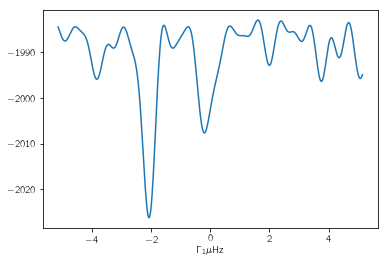

In [95]:
dn = session.run(log_dnu)
grid = np.linspace(-0.3*np.exp(dn),0.3*np.exp(dn), 500)
chi2_grid = gridsearch(session,chi2,gamma,grid,0)
plt.plot(grid, chi2_grid)
plt.xlabel(r'$\Gamma_0 \mu$Hz')
plt.figure()
chi2_grid = gridsearch(session,chi2,gamma,grid,1)
plt.plot(grid, chi2_grid)
plt.xlabel(r'$\Gamma_1 \mu$Hz')
plt.figure()
# chi2_grid = gridsearch(session,chi2,gamma,grid,2)
# plt.plot(grid, chi2_grid)
# plt.xlabel(r'$\Gamma_2 \mu$Hz')

In [96]:
mostvars = granvariables + [log_sigma, log_Q_param, log_H, log_jitter, gamma]
optimize(mostvars)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -2026.417593
  Number of iterations: 21
  Number of functions evaluations: 58


5.3794924375


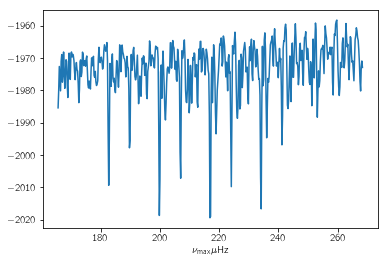

In [97]:
val0, dn = session.run([log_numax, log_dnu])
grid = np.log(np.exp(val0) + np.linspace(-3*np.exp(dn),3*np.exp(dn), 500))
chi2_grid = gridsearch(session,chi2,log_numax,grid, assign=False)
print(grid[np.argmin(chi2_grid)])
session.run(tf.assign(log_numax_param, get_param_for_value(grid[np.argmin(chi2_grid)], *log_numax_range)))

plt.figure()
plt.plot(np.exp(grid), chi2_grid)
plt.xlabel(r'$\nu_\mathrm{max} \mu$Hz')

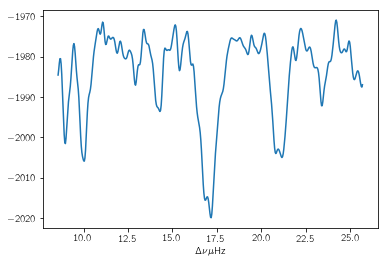

In [98]:
dn = session.run(log_dnu)
grid = np.log(np.linspace(-0.5*np.exp(dn),0.5*np.exp(dn), 500)+np.exp(dn))
chi2_grid = gridsearch(session,chi2,log_dnu,grid,assign=False)
session.run(tf.assign(log_dnu_param, get_param_for_value(grid[np.argmin(chi2_grid)], *log_dnu_range)))

plt.figure()
plt.plot(np.exp(grid), chi2_grid)
plt.xlabel(r'$\Delta\nu \mu$Hz')

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -2028.017153
  Number of iterations: 19
  Number of functions evaluations: 28
[array([-10.16261432,  -9.22107774]), array([ 6.34653462,  4.44381514]), -1.6904921077055031, 0.33985906681089195, array([-3.36503194, -2.52835783]), -3.521524100862603, array([-0.57620514, -2.05840883]), 0.13145937193102855, -1.4092066953589715]


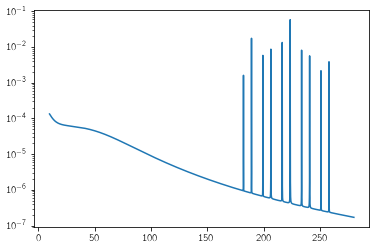

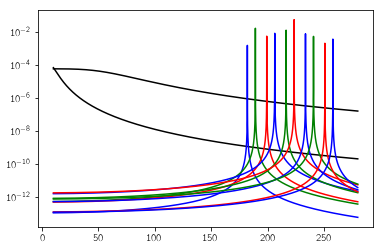

In [99]:
allvars = mostvars + [log_numax_param, log_dnu_param]

optimize(allvars)

plt.figure()
plt.semilogy(*session.run([freq, psd]))

plt.figure()
x, ys = session.run([freq, psds])
for a, b in zip(ys.T, colors):
    plt.semilogy(x, a, color=b)
    
print(session.run(allvars))

In [100]:
session.run(log_Q)

12.089094017208552

(0.0003, 0.03)

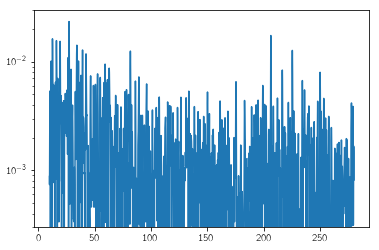

In [101]:
from astropy.stats import LombScargle
freq_muHz = np.linspace(10, 280, 10000)

model = LombScargle(*session.run([t, y[:, 0]]))
power = model.power(session.run(freq))
plt.semilogy(session.run(freq), power)
plt.ylim(3e-4,3e-2)

In [102]:
import tqdm

class HMCSampler(object):
    
    def __init__(self, log_prob, var_list):
        self.var_list = var_list
        self.log_prob = log_prob
        self.grad_log_prob = tf.gradients(log_prob, var_list)
            
    def sample(self, session, nsteps, nintegrate, epsilon, mass=1.0, adapt=False, **kwargs):
        feed_dict = kwargs.pop("feed_dict", {})
        initial_vars = session.run(self.var_list, feed_dict=feed_dict, **kwargs)
        sizes = [np.size(v) for v in initial_vars]
        shapes = [np.shape(v) for v in initial_vars]
        
        def get_feed_dict(vector):
            i = 0
            for var, size, shape in zip(self.var_list, sizes, shapes):
                feed_dict[var] = np.reshape(vector[i:i+size], shape)
                i += size
            return feed_dict
        
        def compute_log_prob(vector):
            try:
                return session.run(self.log_prob, feed_dict=get_feed_dict(vector), **kwargs)
            except tf.errors.InvalidArgumentError:
                print(vector)
                return -np.inf
        
        def compute_grad_log_prob(vector):
            try:
                grad = session.run(self.grad_log_prob, feed_dict=get_feed_dict(vector), **kwargs)
            except tf.errors.InvalidArgumentError:
                print("grad", vector)
                return np.zeros_like(vector)
            return np.concatenate([np.reshape(v, -1) for v in grad])

        initial_q = np.concatenate([np.reshape(v, -1) for v in initial_vars])
        print("initial: ", initial_q)
        initial_log_prob = compute_log_prob(initial_q)
        chain = np.empty((nsteps, len(initial_q)))
        log_prob_chain = np.empty(nsteps)
        accept_count = 0
        nintegrate = np.atleast_1d(nintegrate)
        step_adapt = StepsizeAdaptation(mu=np.log(epsilon))
        for n in tqdm.trange(nsteps):
            q = np.array(initial_q)
            p = np.sqrt(mass) * np.random.randn(len(initial_q))
            factor = 0.5 * np.dot(p, p / mass)

            # First take a half step in momentum.
            p = p + 0.5 * epsilon * compute_grad_log_prob(q)

            # Alternate full steps in position and momentum.
            k = np.random.choice(nintegrate)
            for i in range(k):
                # First, a full step in position.
                q = q + epsilon * p / mass
                # Then a full step in momentum.
                if i < k - 1:
                    p = p + epsilon * compute_grad_log_prob(q)

            # Finish with a half momentum step to synchronize with the position.
            p = p + 0.5 * epsilon * compute_grad_log_prob(q)

            # Negate the momentum. This step really isn't necessary but it doesn't
            # hurt to keep it here for completeness.
            p = -p

            factor -= 0.5 * np.dot(p, p / mass)

            log_prob = compute_log_prob(q)
            lnpdiff = log_prob - initial_log_prob + factor
            accept = 0
            if lnpdiff > 0.0 or np.random.rand() < np.exp(lnpdiff):
                accept_count += 1
                initial_q = q
                initial_log_prob = log_prob
                accept = 1
            chain[n] = initial_q
            log_prob_chain[n] = initial_log_prob
            
            if adapt:
                epsilon = step_adapt.learn_stepsize(accept_count / (n+1))
#                 print(epsilon)
#                 if n >= 100 & (n % 10 == 0):
#                     var = np.var(chain[:n], axis=0)
#                     var_reg = (n / (n + 5.0)) * var + 1e-3 * (5.0 / (n + 5.0))
#                     mass = 1.0 / var_reg
#                     step_adapt.mu = np.log(10 * epsilon)
#                     step_adapt.restart()
#                     print(var_reg)

        print(epsilon)
        feed_dict = get_feed_dict(chain[-1])
        session.run([tf.assign(v, feed_dict[v]) for v in self.var_list], **kwargs)
        
        return chain, log_prob_chain, accept_count

In [103]:
class StepsizeAdaptation(object):
    
    def __init__(self, mu=0.5, delta=0.8, gamma=0.05, kappa=0.75, t0=10):
        self.mu = mu
        self.delta = np.clip(delta, 0.0, 1.0)
        self.gamma = gamma
        self.kappa = kappa
        self.t0 = t0
        self.restart()

    def restart(self):
        self.counter = 0
        self.s_bar = 0.0
        self.x_bar = 0.0
        
    def learn_stepsize(self, accept):
        self.counter += 1
        accept = np.clip(accept, 0.0, 1.0)
        eta = 1.0 / (self.counter + self.t0)
        self.s_bar = (1.0 - eta) * self.s_bar + eta * (self.delta - accept)
        x = self.mu - self.s_bar * np.sqrt(self.counter) / self.gamma
        x_eta = self.counter ** -self.kappa
        self.x_bar = (1.0 - x_eta) * self.x_bar + x_eta * x
        return np.exp(x)

In [107]:
var_list = [log_S0_gran, log_w0_gran, log_sigma, log_Q_param, log_H, log_jitter, gamma, log_numax_param, log_dnu_param]
sampler = HMCSampler(log_prob, var_list)

In [108]:
nintegrate = np.exp(np.linspace(np.log(5), np.log(50), 10)).astype(int)

0.0022360679775
initial:  [-10.16261432  -9.22107774   6.34653462   4.44381514  -1.69049211
   0.33985907  -3.36503194  -2.52835783  -3.5215241   -0.57620514
  -2.05840883   0.13145937  -1.4092067 ]


100%|██████████| 100/100 [01:03<00:00,  2.54it/s]


0.0014926472772
0.82


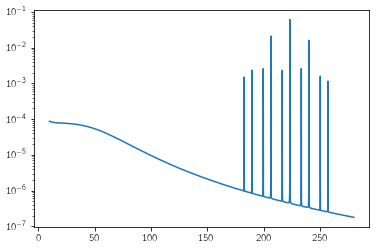

In [109]:
target_acceptance = 0.9
mass = 1.0
nsteps = 100
# log_epsilon_range = np.log([0.0001, 0.05])
# log_epsilon = np.mean(log_epsilon_range)
print(np.exp(log_epsilon))
chain, log_prob_chain, accept_count = sampler.sample(session, nsteps, nintegrate, 0.001, mass, adapt=True)
print(accept_count / nsteps)
plt.semilogy(*session.run([freq, psd]))

In [54]:
chain, log_prob_chain, accept_count = sampler.sample(session, nsteps, nintegrate, 0.0014926472772, mass, adapt=True)
print(accept_count / nsteps)

  1%|          | 1/100 [00:00<00:17,  5.65it/s]

initial:  [-10.24105658  -9.08748284   6.33040244   4.38352164  -1.74688752
   0.368087    -3.3017582   -2.49675932  -3.51698825  -0.47456733
  -2.03600424   5.37987691   2.84300347]


100%|██████████| 100/100 [00:21<00:00,  4.27it/s]

0.000348938074418
0.76


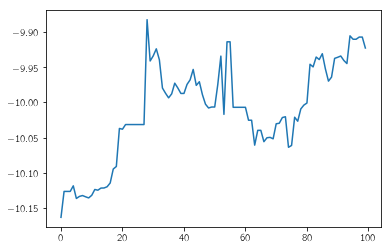

In [111]:
plt.plot(chain[:, 0])

In [112]:
nsteps = 1000
chain, log_prob_chain, accept_count = sampler.sample(session, nsteps, nintegrate, 0.00149, mass, adapt=False)
print(accept_count / nsteps)

  0%|          | 0/1000 [00:00<?, ?it/s]

initial:  [-9.92307226 -9.26482317  6.29788727  3.82176399 -1.62996592  0.55071314
 -3.55960388 -2.48047205 -3.47037229 -0.58472527 -2.28999247  0.13278552
 -1.59234314]


100%|██████████| 1000/1000 [10:05<00:00,  2.11it/s]


0.00149
0.823


In [134]:
for i in range(2):
    if accept_count / nsteps > target_acceptance:
        log_epsilon_range[0] = log_epsilon 
    else:
        log_epsilon_range[1] = log_epsilon
    log_epsilon = np.mean(log_epsilon_range)
    nsteps *= 2
    print(2*accept_count / nsteps, nsteps, nintegrate, np.exp(log_epsilon), mass)
    chain, log_prob_chain, accept_count = sampler.sample(session, nsteps, nintegrate, np.exp(log_epsilon), mass)
    print(accept_count / nsteps)

  1%|          | 1/160 [00:00<00:20,  7.77it/s]

0.9375 160 [ 4  6  8 10 13 17 23 29 38 49] 0.000320668924952 1.0
initial:  [-10.22522782  -9.16258381   6.3452374    4.41781318  -1.7524063
   0.40518077  -3.37210024  -2.45320886  -3.54045186  -0.56434308
  -2.01397921   5.37966389   2.84319043]


  0%|          | 0/320 [00:00<?, ?it/s]

0.65
0.65 320 [ 4  6  8 10 13 17 23 29 38 49] 0.00026406695842 1.0
initial:  [-10.14719953  -9.18772484   6.42359173   4.44451303  -1.8721626
   0.41043637  -3.32527971  -2.50642831  -3.57159849  -0.52091094
  -2.09962196   5.38002553   2.8435783 ]


100%|██████████| 320/320 [01:10<00:00,  5.93it/s]


0.790625


In [141]:
var = np.var(chain, axis=0)
n = len(chain)
var_reg = (n / (n + 5.0)) * var + 1e-3 * (5.0 / (n + 5.0))

# epsilon = np.exp(log_epsilon) / np.mean(1.0 / mass)
# epsilon, mass

In [142]:
var, var_reg

(array([  1.73790442e-03,   7.66194360e-04,   2.14904974e-03,
          2.59762610e-03,   3.21320057e-03,   1.07239468e-03,
          7.07247438e-04,   4.12394320e-03,   1.09297164e-03,
          1.06158139e-03,   1.95580519e-03,   2.25834861e-07,
          2.28039798e-04]),
 array([  1.72655205e-03,   7.69791370e-04,   2.13137206e-03,
          2.57304723e-03,   3.17915133e-03,   1.07128091e-03,
          7.11751324e-04,   4.07588254e-03,   1.09154131e-03,
          1.06063398e-03,   1.94110050e-03,   1.56069759e-05,
          2.39916109e-04]))

In [32]:
chain, log_prob_chain, accept_count = sampler.sample(session, 100, nintegrate, epsilon, mass)
accept_count / 100

  0%|          | 0/100 [00:00<?, ?it/s]

initial:  [-10.14807766  -9.18147993   6.44436445   4.40198095  -0.53829489
  11.58284183  -3.71377358  -3.15594494  -3.52344698  -0.54861881
  -2.01393734   5.37988057   2.84392487]


100%|██████████| 100/100 [00:19<00:00,  4.46it/s]


0.94

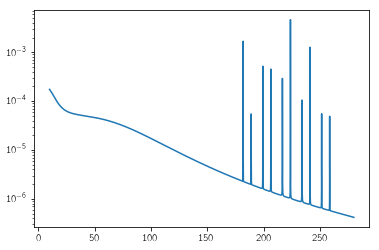

In [38]:
plt.semilogy(*session.run([freq, psd]))

In [46]:
chain, log_prob_chain, accept_count = sampler.sample(session, 10000, nintegrate, epsilon, mass)
accept_count / 10000

  0%|          | 1/10000 [00:00<26:07,  6.38it/s]

initial:  [ -9.94358502  -9.21661369   6.22550149   4.18038023   1.8294395
  10.58219884  -3.67995545  -4.4062692   -3.46389179   1.07941793
  -0.61033981   5.37245344   2.82053734]


100%|██████████| 10000/10000 [9:13:29<00:00,  6.20it/s]


0.9174

In [47]:
# chain, log_prob_chain, accept_count = sampler.sample(session, 1000, nintegrate, np.exp(log_epsilon), sigma)

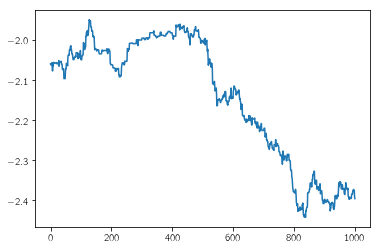

In [65]:
plt.plot(chain[:, -3])

['log S0 gran 41', 'log S0 gran 42', 'log w0 gran 41', 'log w0 gran 42', 'log sigma 4', 'log Q param 5', 'log H 41', 'log H 42', 'log jitter 4', 'gamma 41', 'gamma 42', 'log numax 4', 'log dnu 4']


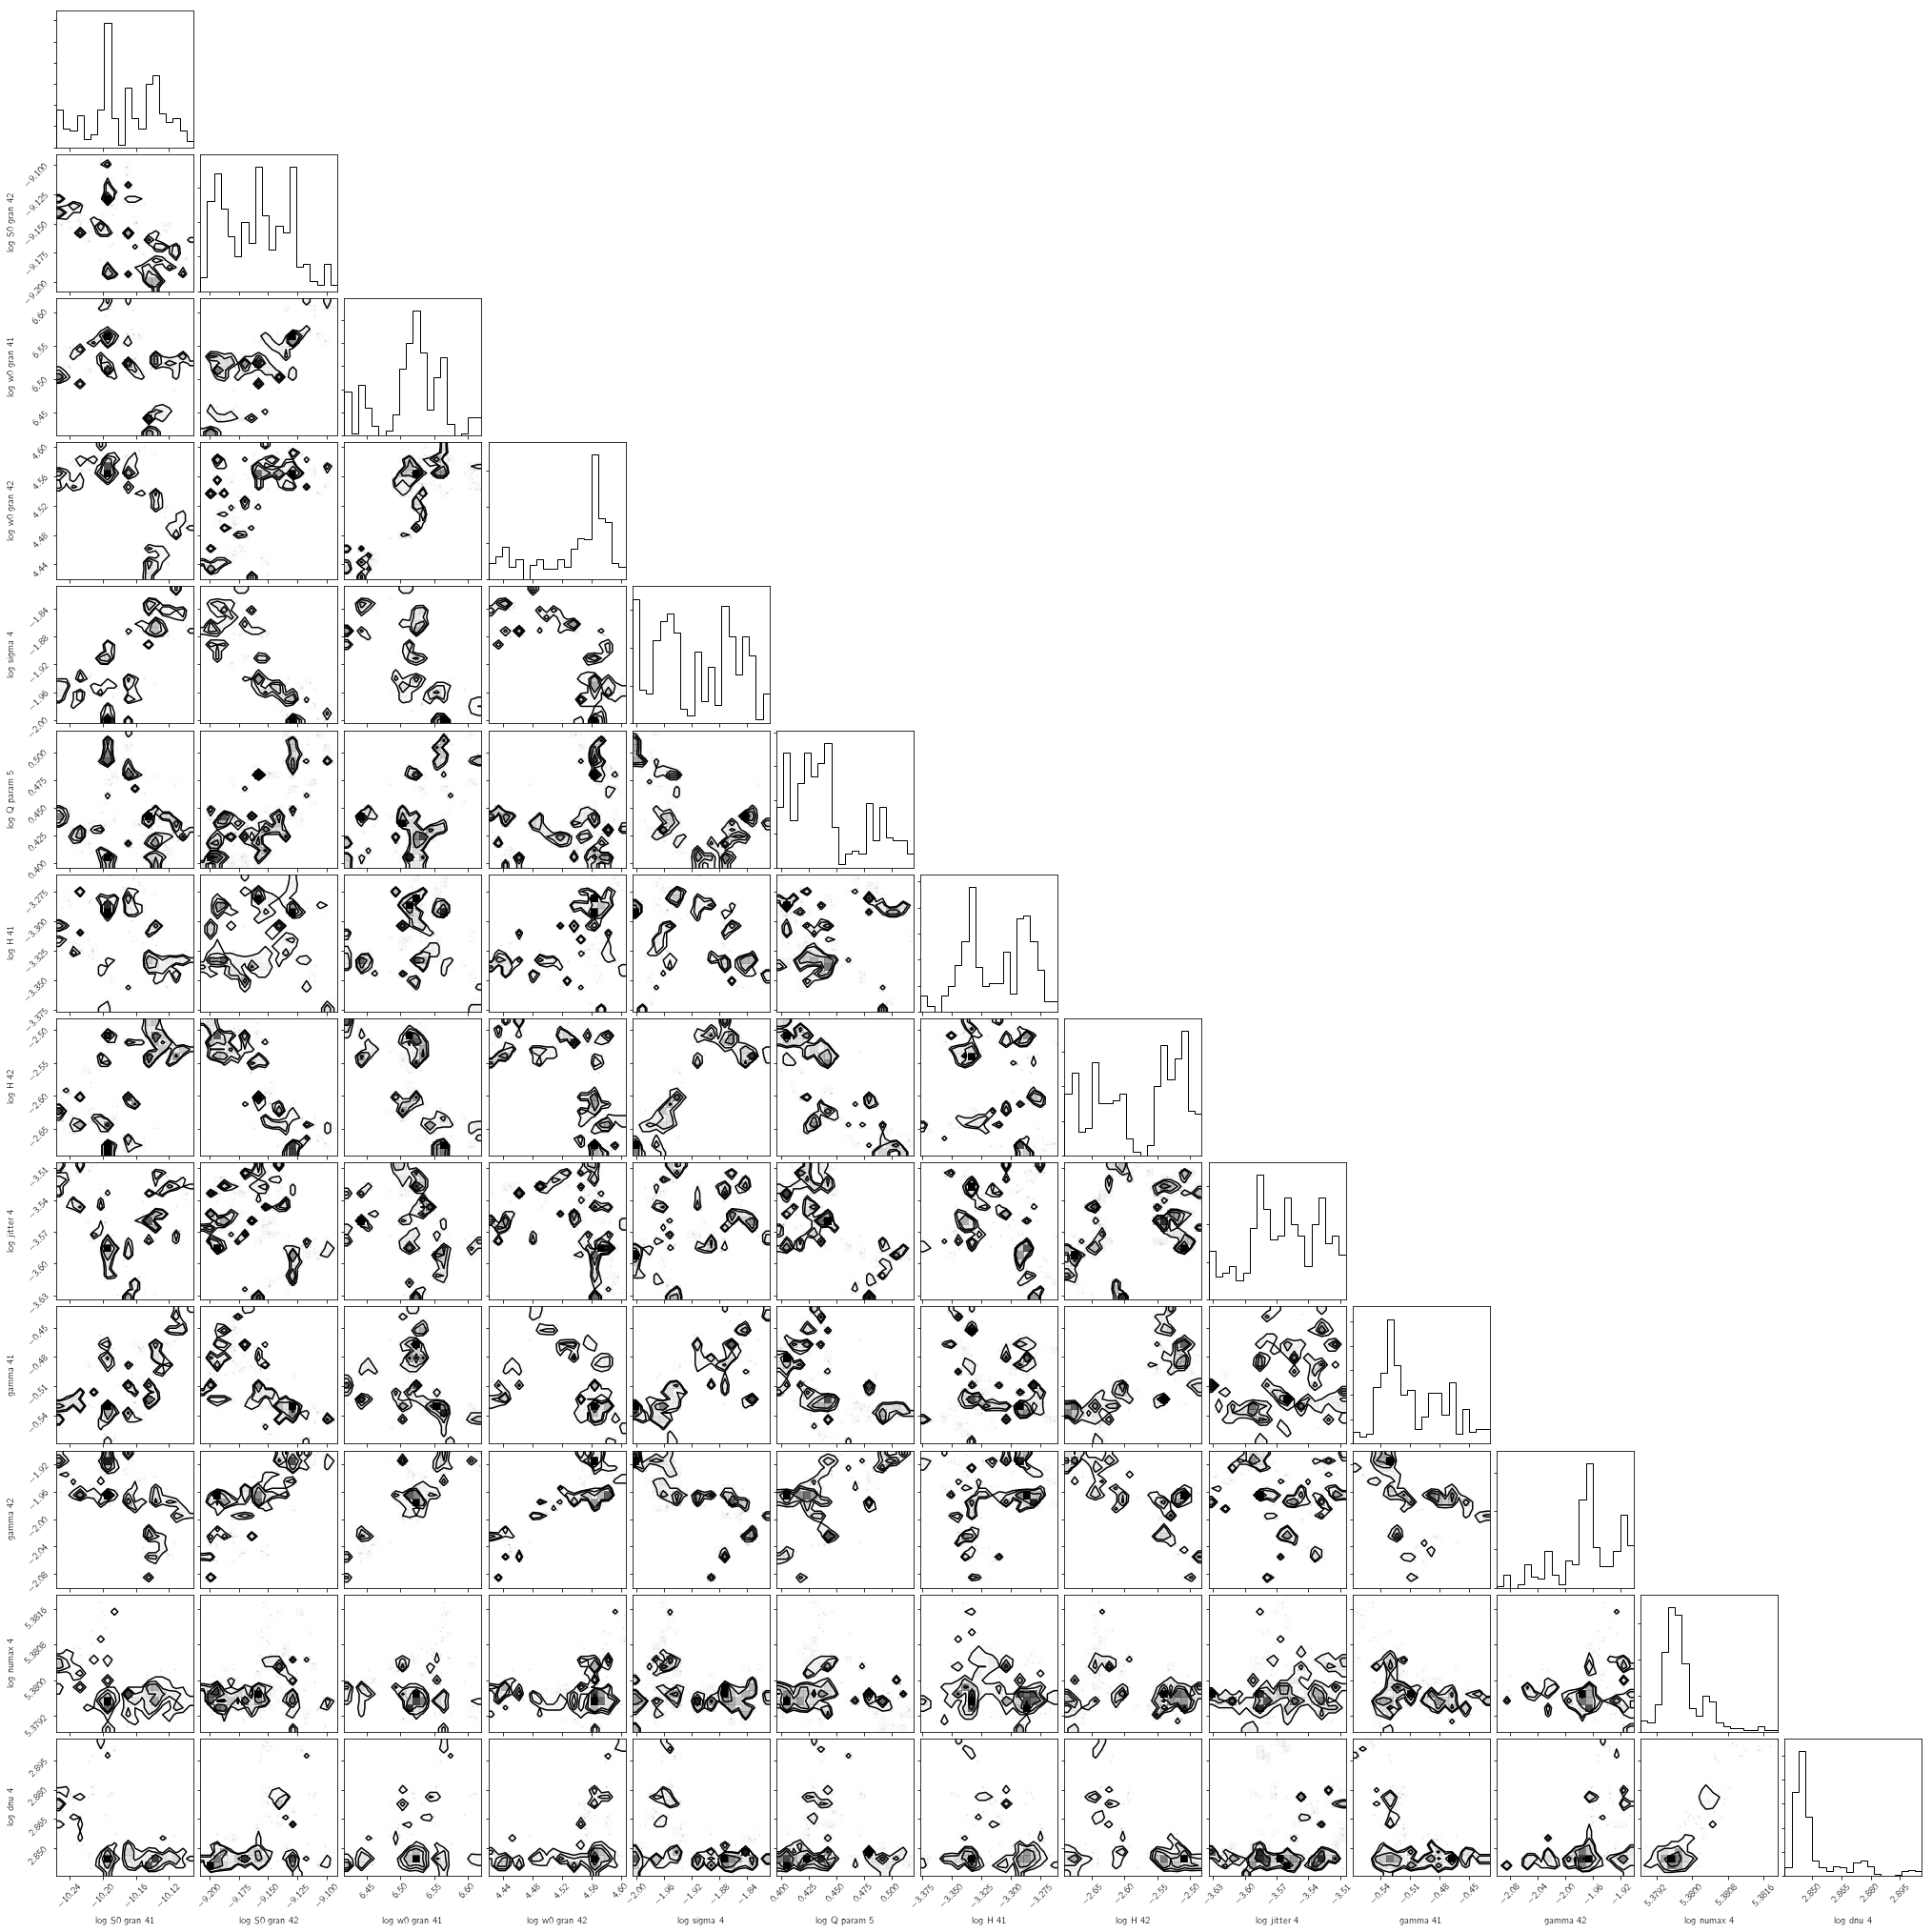

In [140]:
import corner

names = []
sizes = [np.size(v) for v in session.run(var_list)]
for var, size in zip(var_list, sizes):
    if size > 1:
        for i in range(size):
            names.append(var.name[:-2].replace("_", " ") + "{0}".format(i+1))
    else:
        names.append(var.name[:-2].replace("_", " "))
print(names)
corner.corner(chain, labels=names);

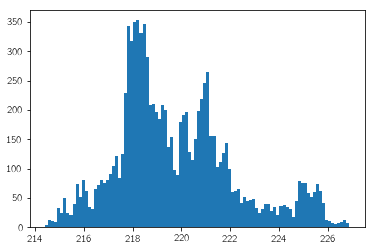

In [52]:
plt.hist(np.exp(chain[:, -2]), 100);

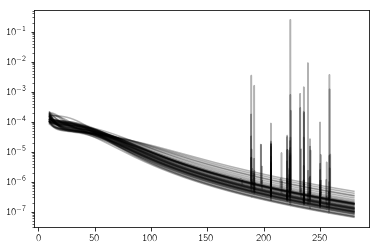

In [55]:
initial_vars = session.run(var_list)
sizes = [np.size(v) for v in initial_vars]
shapes = [np.shape(v) for v in initial_vars]

def get_feed_dict(vector):
    i = 0
    feed_dict = {}
    for var, size, shape in zip(var_list, sizes, shapes):
        feed_dict[var] = np.reshape(vector[i:i+size], shape)
        i += size
    return feed_dict

for s in chain[np.random.randint(len(chain), size=50)]:
    plt.semilogy(*session.run([freq, psd], feed_dict=get_feed_dict(s)), color="k", alpha=0.3)

In [93]:
import emcee
# var_list = [log_S0_gran, log_w0_gran]
initial_vars = session.run(var_list)
sizes = [np.size(v) for v in initial_vars]
shapes = [np.shape(v) for v in initial_vars]

def get_feed_dict(vector):
    i = 0
    feed_dict = {}
    for var, size, shape in zip(var_list, sizes, shapes):
        feed_dict[var] = np.reshape(vector[i:i+size], shape)
        i += size
    return feed_dict

def emcee_log_prob(vector):
    if np.any(vector < -15) or np.any(vector > 15):
        return -np.inf
    return session.run(log_prob, feed_dict=get_feed_dict(vector))

# p0 = np.concatenate([np.reshape(v, -1) for v in initial_vars])
# p0 = p0 + 1e-5 * np.random.randn(16, len(p0))
nwalkers = 32
p0 = chain[np.random.randint(len(chain), size=nwalkers)]
nwalkers, ndim = p0.shape
emcee_sampler = emcee.EnsembleSampler(nwalkers, ndim, emcee_log_prob)
pos, _, _ = emcee_sampler.run_mcmc(p0, 1000);

/Users/dforeman/research/projects/emcee/emcee/moves/red_blue.py:96: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - log_probs[j]


In [69]:
pos, _, _ = emcee_sampler.run_mcmc(pos, 1000);

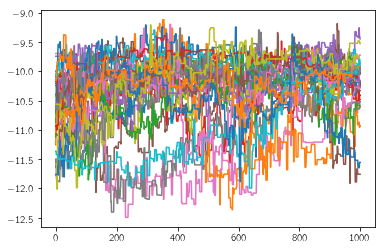

In [94]:
plt.plot(emcee_sampler.chain[:, :, 0].T);

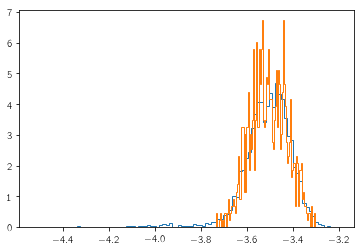

In [98]:
plt.hist(emcee_sampler.chain[:, :, -3].flatten(), 100, histtype="step", normed=True)
plt.hist(chain[:, -3], 100, histtype="step", normed=True);